In [86]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
import pandas as pd
import numpy as np
import gtfs_kit as gk
import matplotlib.pyplot as plt

from shapely import geometry


%matplotlib inline
ox.config(log_console=True)
ox.__version__

data_dir = '../data/'

In [2]:
feed=gk.read_feed('data/stm.zip',dist_units='km')

In [3]:
trip = feed.stop_times[feed.stop_times['trip_id']=='205408909']

In [20]:
trip=trip.merge(feed.stops[['stop_id','stop_lat','stop_lon']],left_on='stop_id',right_on='stop_id')

In [21]:
meili_df = trip[['departure_time','stop_lat','stop_lon']].rename(columns={'departure_time':'time','stop_lat':'lat','stop_lon':'lon'})

In [22]:
meili_df


,time,lat,lon
0,05:13:00,45.530024,-73.623756
1,05:14:51,45.529510,-73.622634
2,05:16:12,45.532296,-73.620360
3,05:17:00,45.533908,-73.618877
4,05:17:15,45.535046,-73.617454
5,05:17:42,45.537393,-73.615162
6,05:18:00,45.538922,-73.613838
7,05:18:48,45.540498,-73.613116
8,05:19:48,45.542320,-73.612026
9,05:20:39,45.543771,-73.610716


In [23]:
meili_coordinates = meili_df.to_json(orient='records')


In [183]:

# Providing needed data for the body of Meili's request
meili_head = '{"shape":'
# Those are parameters that you can change according to the Meili's documentation
#meili_tail = ""","costing":"auto","shape_match":"walk_or_snap","filters":{"attributes":["edge.names","edge.id","matched.point","matched.type","matched.edge_index","matched.begin_route_discontinuity","matched.end_route_discontinuity"],"action":"include"}} """
meili_tail = ""","costing":"auto","shape_match":"walk_or_snap","filters":{"attributes":["edge.names","edge.way_id","matched.point","matched.type","matched.edge_index"],"action":"include"}} """

# Combining all the string into a single request
meili_request_body = meili_head + meili_coordinates + meili_tail

In [184]:
meili_request_body

'{"shape":[{"time":"05:13:00","lat":45.530024,"lon":-73.623756},{"time":"05:14:51","lat":45.52951,"lon":-73.622634},{"time":"05:16:12","lat":45.532296,"lon":-73.62036},{"time":"05:17:00","lat":45.533908,"lon":-73.618877},{"time":"05:17:15","lat":45.535046,"lon":-73.617454},{"time":"05:17:42","lat":45.537393,"lon":-73.615162},{"time":"05:18:00","lat":45.538922,"lon":-73.613838},{"time":"05:18:48","lat":45.540498,"lon":-73.613116},{"time":"05:19:48","lat":45.54232,"lon":-73.612026},{"time":"05:20:39","lat":45.543771,"lon":-73.610716},{"time":"05:21:30","lat":45.545235,"lon":-73.609413},{"time":"05:22:19","lat":45.546606,"lon":-73.608136},{"time":"05:23:00","lat":45.547776,"lon":-73.607085},{"time":"05:23:28","lat":45.548962,"lon":-73.60601},{"time":"05:23:55","lat":45.550115,"lon":-73.604994},{"time":"05:24:32","lat":45.551701,"lon":-73.603602},{"time":"05:25:00","lat":45.55289,"lon":-73.602551},{"time":"05:25:13","lat":45.553481,"lon":-73.602022},{"time":"05:25:40","lat":45.55472,"lon":

In [197]:
# The URL of our local Valhalla server
# "trace_route" means that we're sening a request to Meili
url = "http://localhost:8002/trace_attributes"

# Providing headers to the request
headers = {'Content-type': 'application/json'}

# We need to send our JSON as a string
data = str(meili_request_body)

# Sending a request
r = requests.post(url, data=data, headers=headers)

In [198]:
r

<Response [400]>

In [187]:
import json
# Checking if the response from Meili was correct
if r.status_code == 200:
    # Parsing the JSON response
    response_text = json.loads(r.text)
    
    # There are a lot more information that we got from Meili
    # but I'm interested in just 'tracepoints'
    resp = str(response_text['matched_points'])
    
    # This is a replacement to distinguish single None's in a row
    # from "waypoint_index" being None
    #resp = resp.replace("'waypoint_index': None", "'waypoint_index': '#'")
    #resp = resp.replace("None", "{'matchings_index': '#', 'name': '', 'waypoint_index': '#', 'alternatives_count': 0, 'distance': 0, 'location': [0.0, 0.0]}")
    
    # This is to make it a valid JSON
    resp = resp.replace("'", '"')
    resp = json.dumps(resp)
    resp = json.loads(resp)
    
    # Reading our JSON to a Pandas DataFrame
    df_response = pd.read_json(resp)
    df_response.rename(columns={'lat':'matched_lat','lon':'matched_lon'},inplace=True)
    
    
    # Merging our initial data with the response from Meili by index
    df_trip_optimized = pd.merge(meili_df, df_response, left_index=True, right_index=True)

In [188]:

df_trip_optimized
df_response

,edge_index,type,matched_lat,matched_lon
0,0,matched,45.529971,-73.623787
1,3,matched,45.529638,-73.622700
2,0,matched,45.532342,-73.620461
3,0,matched,45.533954,-73.618978
4,0,matched,45.535118,-73.617532
5,0,matched,45.537433,-73.615248
6,0,matched,45.538935,-73.613878
7,0,matched,45.540516,-73.613191
8,0,matched,45.542364,-73.612132
9,0,matched,45.543819,-73.610823


In [189]:
# define a point
location_point = tuple(df_trip_optimized[['lat','lon']].iloc[10])

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=2500,
                        dist_type='bbox', network_type='drive')


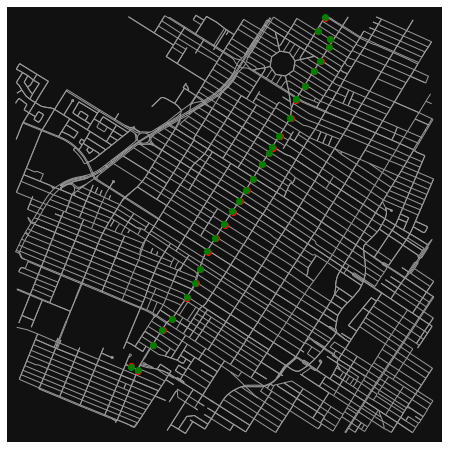

In [190]:
fig, ax = ox.plot_graph(G,node_size=0, show=False, close=False)
ax.scatter(df_trip_optimized['lon'],df_trip_optimized['lat'],c='r')
ax.scatter(df_trip_optimized['matched_lon'],df_trip_optimized['matched_lat'],c='g')
plt.show()

In [191]:
response_text

{'matched_points': [{'edge_index': 0,
   'type': 'matched',
   'lat': 45.529971,
   'lon': -73.623787},
  {'edge_index': 3, 'type': 'matched', 'lat': 45.529638, 'lon': -73.6227},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.532342, 'lon': -73.620461},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.533954, 'lon': -73.618978},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.535118, 'lon': -73.617532},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.537433, 'lon': -73.615248},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.538935, 'lon': -73.613878},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.540516, 'lon': -73.613191},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.542364, 'lon': -73.612132},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.543819, 'lon': -73.610823},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.545281, 'lon': -73.609518},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.546645, 'lon': -73.608215},
  {'edge_index': 0, 'type': 'matched', 'lat': 45.54

In [192]:
resp_edges = str(response_text['edges'])
resp_edges = resp_edges.replace("'", '"')
resp_edges = json.dumps(resp_edges)
resp_edges = json.loads(resp_edges)
    
    # Reading our JSON to a Pandas DataFrame
df_edges = pd.read_json(resp_edges)

In [193]:
df_edges

,names,way_id
0,[Rue Hutchison],165096613
1,[Rue Hutchison],165096613
2,[Rue Hutchison],165096613
3,[Rue Jean-Talon Ouest],184778964
4,[Rue Jean-Talon Ouest],184778963
...,...,...
95,[Rue Jean-Talon Est],37859259
96,[20e Avenue],20441264
97,[Rue Everett],47344820
98,[Rue Everett],47344820


In [194]:
df_edges.iloc[99]

names     [Rue Everett]
way_id         47344820
Name: 99, dtype: object

In [195]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
26232411,45.524984,-73.582009,traffic_signals,3,NaN,POINT (-73.58201 45.52498)
26232412,45.524531,-73.582404,traffic_signals,4,NaN,POINT (-73.58240 45.52453)
26232413,45.523974,-73.582902,traffic_signals,4,NaN,POINT (-73.58290 45.52397)
26232418,45.522917,-73.583830,NaN,4,NaN,POINT (-73.58383 45.52292)
29287991,45.533508,-73.615736,NaN,3,NaN,POINT (-73.61574 45.53351)


<AxesSubplot:>

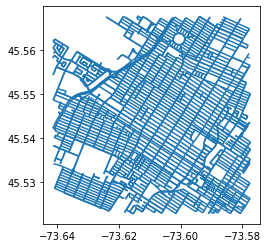

In [134]:
gdf_edges.plot()

In [196]:
gdf_edges[gdf_edges['osmid']=='165096613']
#gdf_edges

,,,osmid,lanes,name,highway,oneway,length,maxspeed,geometry,ref,junction,access,bridge,tunnel
u,v,key,,,,,,,,,,,,,


In [149]:
for index in gdf_edges.index:
    

True